<a href="https://colab.research.google.com/github/Nayana-saikumar/ybi_project/blob/main/Yet_another_copy_of_Eye_diseases_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python --version

Python 3.10.12


Dataset link-  https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download gunavenkatdoddi/eye-diseases-classification
!unzip eye-diseases-classification.zip

## Eye diseases

Diabetes is a condition that carries an increased risk of developing eye complications. Diabetic eye disease includes complications such as diabetic retinopathy, cataracts and glaucoma.

Diabetes is the leading cause of blindness in working-age adults. People with type 1 and type 2 diabetes are at risk. It’s possible to be unaware that you have severe diabetic eye disease and suddenly go blind. Fortunately, most cases of blindness can be prevented with regular eye examinations and proper care.

- The dataset consists of Normal, Diabetic Retinopathy, Cataract and Glaucoma retinal images where each class have approximately 1000 images. These images are collected from various sorces like IDRiD, Oculur recognition, HRF etc.

- Diabetic retinopathy: The persistently high blood sugar levels that occur with diabetes can damage the retina’s small blood vessels (capillaries), which deliver oxygen and nutrients. Diabetic retinopathy affects up to a third of people with diabetes over the age of 502.

- Cataracts: A cataract is a clouding of the lens in the eye. Left untreated, cataracts can eventually lead to blindness. People with diabetes are more likely to develop cataracts at an earlier age and suffer visual impairment faster than those without the condition.1,3

- Glaucoma: This is a group of conditions that can damage the optic nerve. The optic nerve transmits signals from the retina to the brain for processing. Glaucoma is often (but not always) a result of increased pressure inside the eye. The risk of glaucoma in people with diabetes is significantly higher than that of the general population.1,4 The two main types are open-angle glaucoma (also called ‘the sneak thief of sight’) and angle-closure glaucoma (this comes on suddenly and is a medical emergency).

## Import Libraries

# New Section

In [ ]:
# import system libs
import os
import time
# import data handling tools
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Activation, GlobalAveragePooling2D
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

## Class for Loading and Splitting Datasets

In [ ]:
class EyeDiseaseDataset:
    def __init__(self, dataDir):
        self.data_dir = dataDir

    def dataPaths(self):
        filepaths = []
        labels = []
        folds = os.listdir(self.data_dir)
        for fold in folds:
            foldPath = os.path.join(self.data_dir, fold)
            filelist = os.listdir(foldPath)
            for file in filelist:
                fpath = os.path.join(foldPath, file)
                filepaths.append(fpath)
                labels.append(fold)
        return filepaths, labels

    def dataFrame(self, files, labels):

        Fseries = pd.Series(files, name='filepaths')
        Lseries = pd.Series(labels, name='labels')
        return pd.concat([Fseries, Lseries], axis=1)

    def split_(self):
        files, labels = self.dataPaths()
        df = self.dataFrame(files, labels)
        strat = df['labels']
        trainData, dummyData = train_test_split(df, train_size=0.8, shuffle=True, random_state=42, stratify=strat)
        strat = dummyData['labels']
        validData, testData = train_test_split(dummyData, train_size=0.5, shuffle=True, random_state=42, stratify=strat)
        return trainData, validData, testData

In [ ]:
dataDir='dataset'

In [ ]:
dataSplit = EyeDiseaseDataset(dataDir)
train_data, valid_data, test_data = dataSplit.split_()

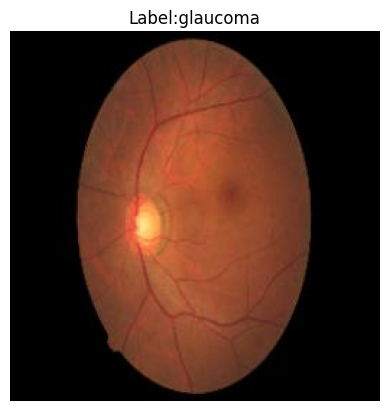

In [ ]:
def display_random_image(df):
    random_row = df.sample(1).iloc[0]
    filepath = random_row['filepaths']
    label = random_row['labels']

    img = Image.open(filepath)
    plt.imshow(img)
    plt.title(f'Label:{label}')
    plt.axis('off')
    plt.show()

display_random_image(train_data)

## Function for Data Augmentation

In [ ]:
def augment_data( train_df, valid_df, test_df, batch_size=16):

    img_size = (256,256)
    channels = 3
    color = 'rgb'


    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
              rotation_range=30,
              horizontal_flip=True,
              vertical_flip=True,
              brightness_range=[0.5, 1.5])

    valid_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

    train_generator = train_datagen.flow_from_dataframe(
              train_df,
              x_col='filepaths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=True,
              class_mode='categorical'
          )

    print("Shape of augmented training images:", train_generator.image_shape)

    valid_generator = valid_test_datagen.flow_from_dataframe(
              valid_df,
              x_col='filepaths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=True,
              class_mode='categorical'
          )

    print("Shape of validation images:", valid_generator.image_shape)

    test_generator = valid_test_datagen.flow_from_dataframe(
              test_df,
              x_col='filepaths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=False,
              class_mode='categorical'
          )

    print("Shape of test images:", test_generator.image_shape)

    return train_generator, valid_generator, test_generator

In [ ]:
train_augmented, valid_augmented, test_augmented = augment_data(train_data, valid_data, test_data)

Found 3373 validated image filenames belonging to 4 classes.
Shape of augmented training images: (256, 256, 3)
Found 422 validated image filenames belonging to 4 classes.
Shape of validation images: (256, 256, 3)
Found 422 validated image filenames belonging to 4 classes.
Shape of test images: (256, 256, 3)


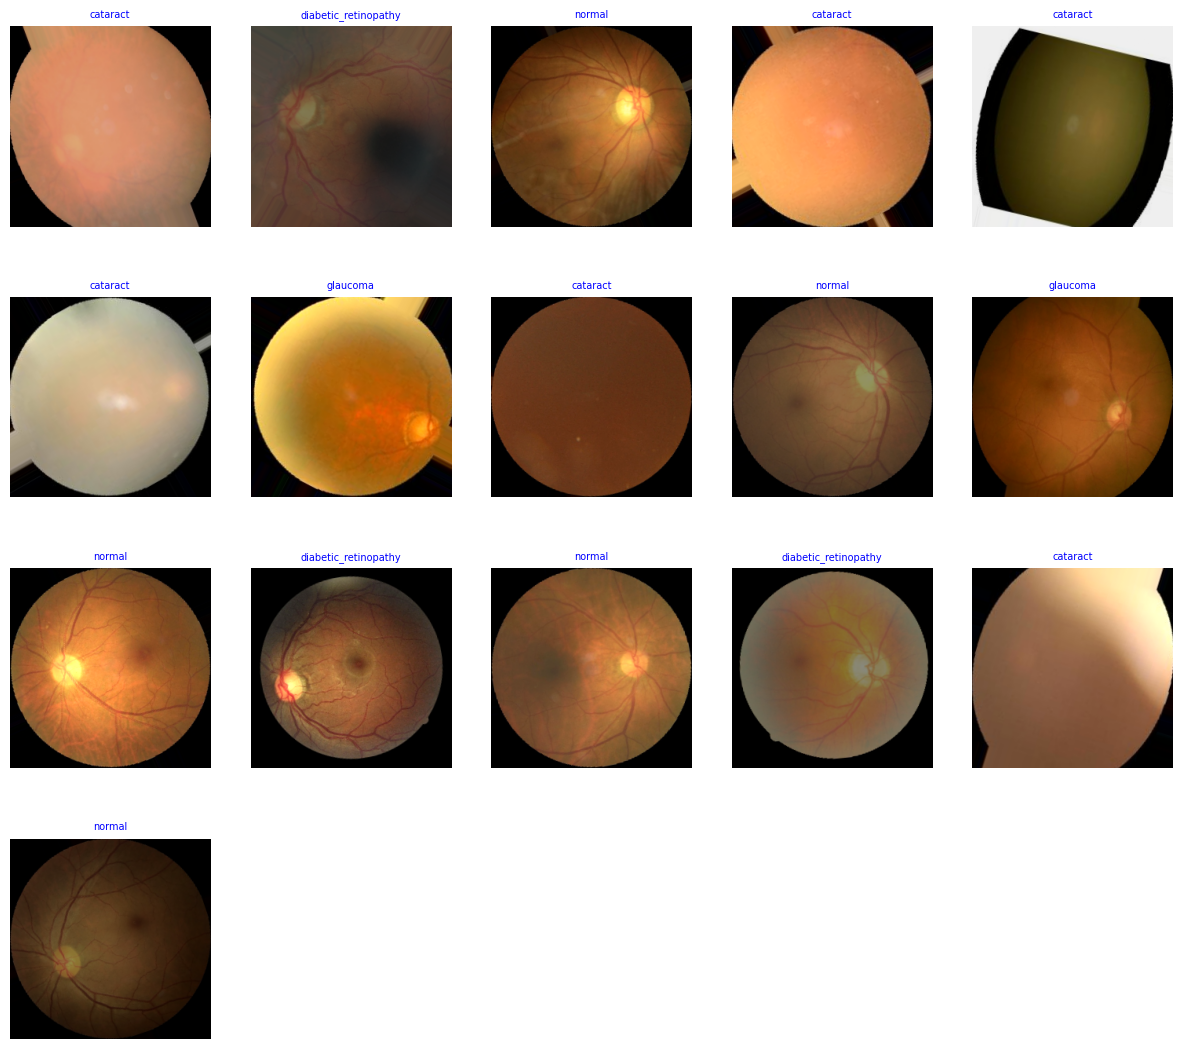

In [ ]:
def show_images(gen):

    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator
    length = len(labels)
    sample = min(length, 20)
    plt.figure(figsize= (15, 17))
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color= 'blue', fontsize= 7 )
        plt.axis('off')
    plt.show()
show_images(train_augmented)

## Download and compile the model

In [ ]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import regularizers

classes = len(list(train_augmented.class_indices.keys()))

base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu' , kernel_regularizer = regularizers.l2(0.01))(x)

predictions = Dense(classes, activation='softmax', kernel_regularizer = regularizers.l2(0.01))(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
history = model.fit(
    train_augmented,
    epochs=15,
    validation_data=valid_augmented
)

Epoch 1/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 163s 571ms/step - accuracy: 0.6750 - loss: 4.2043 - val_accuracy: 0.7109 - val_loss: 1.0406
Epoch 2/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 138s 374ms/step - accuracy: 0.7364 - loss: 0.9500 - val_accuracy: 0.7322 - val_loss: 0.8284
Epoch 3/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 80s 371ms/step - accuracy: 0.7691 - loss: 0.7697 - val_accuracy: 0.6564 - val_loss: 0.9065
Epoch 4/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 81s 368ms/step - accuracy: 0.7547 - loss: 0.7681 - val_accuracy: 0.7251 - val_loss: 0.7722
Epoch 5/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 82s 366ms/step - accuracy: 0.7588 - loss: 0.7508 - val_accuracy: 0.6967 - val_loss: 0.8487
Epoch 6/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 82s 369ms/step - accuracy: 0.7572 - loss: 0.7585 - val_accuracy: 0.6374 - val_loss: 1.0337
Epoch 7/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 80s 367ms/step - accuracy: 0.7564 - loss: 0.7591 - val_accuracy: 0.6801 - val_loss: 0.8483
Epoch 8/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 83s 368ms/step - accuracy: 0.7470 - loss:

## Fit the model

## Plot the Accuracy and Loss

Training Accuracy: 0.7918766736984253
Validation Accuracy: 0.7061611413955688


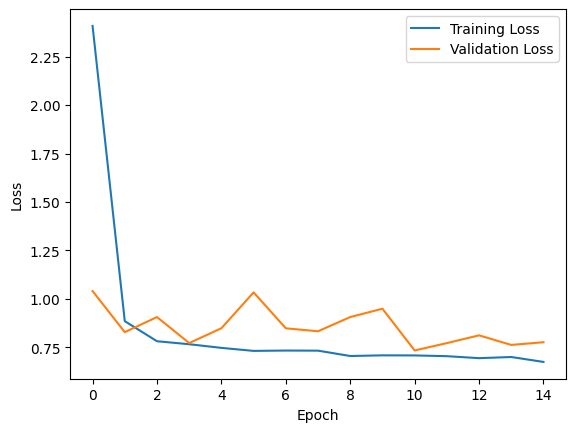

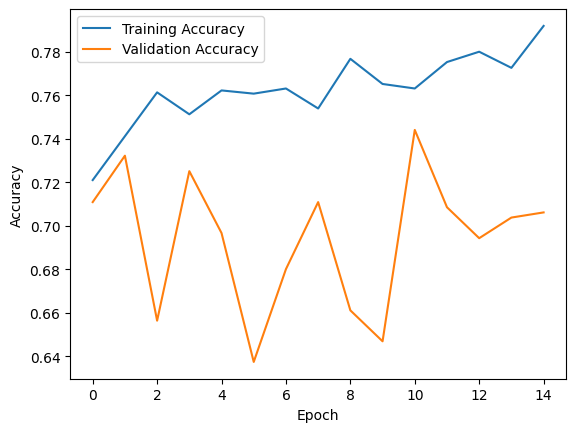

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
print("Training Accuracy:", train_accuracy[-1])
print("Validation Accuracy:", val_accuracy[-1])
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Display the Actual and Predicted images

# New section

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


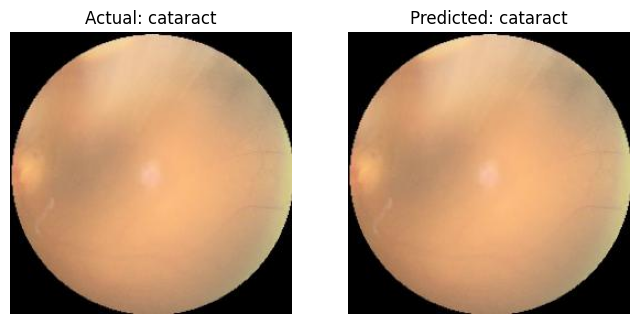

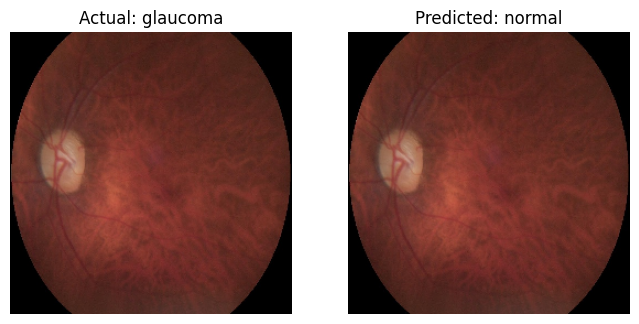

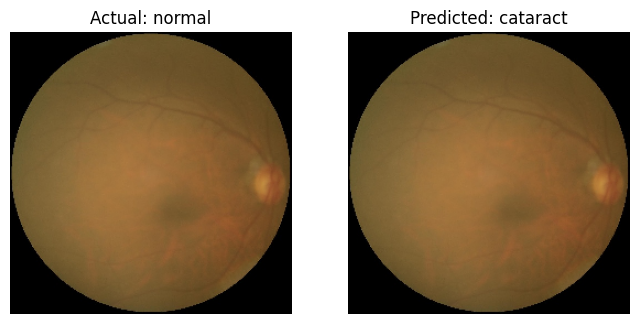

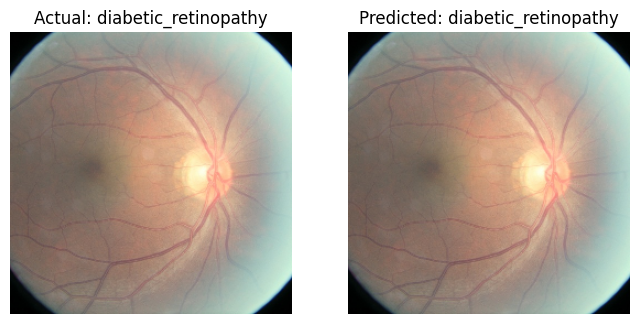

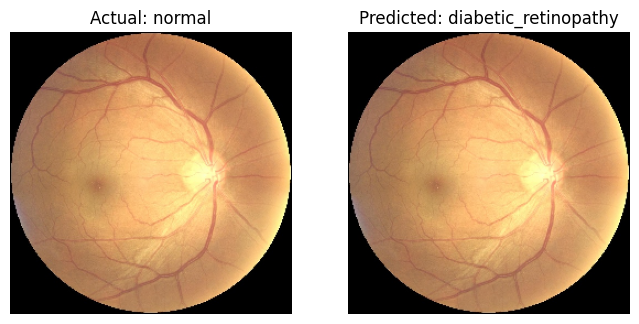

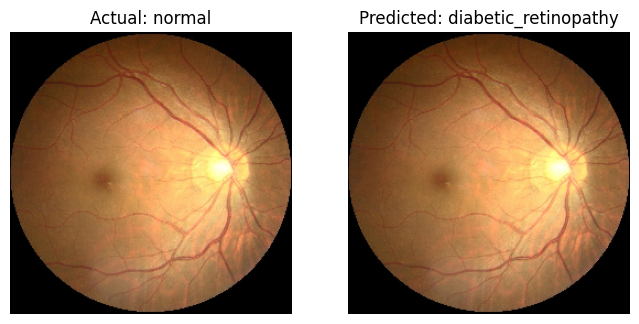

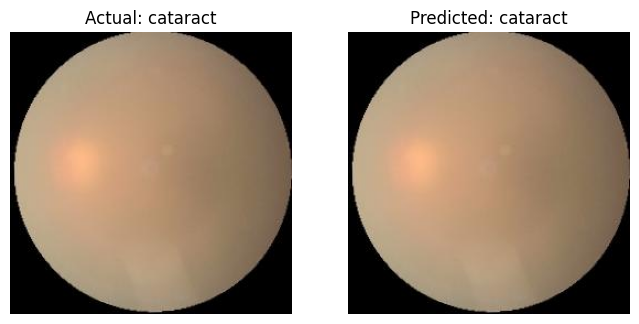

In [ ]:
def plot_actual_vs_predicted(model, test_data, num_samples=7):

    # Get a batch of test data
    test_images, test_labels = next(iter(test_data))

    predictions = model.predict(test_images)

    class_labels = list(train_augmented.class_indices.keys())

    sample_indices = np.random.choice(range(len(test_images)), num_samples, replace=False)
      # Plot the images with actual and predicted labels
    for i in sample_indices:
        actual_label = class_labels[np.argmax(test_labels[i])]
        predicted_label = class_labels[np.argmax(predictions[i])]
        plt.figure(figsize=(8, 4))
        # Actual Image
        plt.subplot(1, 2, 1)
        plt.imshow(test_images[i].astype(np.uint8))
        plt.title(f'Actual: {actual_label}')
        plt.axis('off')
        # Predicted Image
        plt.subplot(1, 2, 2)
        plt.imshow(test_images[i].astype(np.uint8))
        plt.title(f'Predicted: {predicted_label}')
        plt.axis('off')
        plt.show()
plot_actual_vs_predicted(model, test_augmented)

In [ ]:

model.save('eye.h5')

In [ ]:
class_labels = list(train_augmented.class_indices.keys())

In [ ]:
class_labels

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [ ]:
len(test_augmented)

27

In [ ]:
# prompt: find index of 1 in array

import numpy as np
arr = np.array([0, 1, 0, 1, 0])
index_of_ones = np.where(arr == 1)[0]
print(index_of_ones)


[1 3]


In [ ]:

test_images, test_labels = next(iter(test_augmented))
predictions = model.predict(test_images)
i=0
for p in predictions:
  print(test_labels[i], class_labels[np.argmax(p)])
  i+=1



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[0. 0. 0. 1.] diabetic_retinopathy
[0. 0. 0. 1.] diabetic_retinopathy
[1. 0. 0. 0.] glaucoma
[0. 0. 1. 0.] glaucoma
[0. 0. 1. 0.] normal
[0. 0. 0. 1.] diabetic_retinopathy
[0. 1. 0. 0.] diabetic_retinopathy
[0. 0. 0. 1.] normal
[0. 1. 0. 0.] diabetic_retinopathy
[0. 0. 1. 0.] normal
[0. 0. 0. 1.] normal
[0. 0. 0. 1.] glaucoma
[0. 0. 0. 1.] normal
[0. 1. 0. 0.] diabetic_retinopathy
[0. 1. 0. 0.] diabetic_retinopathy
[1. 0. 0. 0.] cataract


In [ ]:
class_labels[np.argmax(predictions[0])]


'diabetic_retinopathy'

In [ ]:
pip install gradio

In [ ]:
import numpy as np
import tensorflow as tf
import gradio as gr
def your_fuction(input):
  #your function implementation
  return output
#define your gradio interface
  iface = gr.Interface(fn=your_function,inputs="text",outputs="text")
#launch the gradio interface
  iface.launch(share=true,debug=False)
# Load the trained model
model = tf.keras.models.load_model('/content/eye.h5')

# Assuming you have a way to get class labels from your model or training data
# Replace 'train_augmented.class_indices.keys()' with actual class labels if needed
class_labels = ['glaucoma', 'diabetic_retinopathy', 'cataract', 'normal']

# Define a function to predict the eye disease
def predict_eye_disease(image):
    # Preprocess the image
    image = np.array(image)  # Convert to numpy array
    image = tf.image.resize(image, (256, 256))  # Resize image to (256, 256)
    # image = image / 255.0  # Normalize image

    # Add batch dimension
    image = np.expand_dims(image, axis=0)

    # Predict the eye disease
    prediction = model.predict(image)

    # Get the class label of the prediction
    predicted_label = class_labels[np.argmax(prediction[0])]

    # Return the predicted label
    return predicted_label

# Create a Gradio interface
image_input = gr.Image(type="numpy")  # Set type to numpy to handle the image correctly
label_output = gr.Label(num_top_classes=4)  # Adjust the number of top classes as needed

interface = gr.Interface(
    fn=predict_eye_disease,
    inputs=image_input,
    outputs=label_output,
    examples=[
        '/kaggle/input/eye-diseases-classification/dataset/cataract/0_left.jpg',
        '/kaggle/input/eye-diseases-classification/dataset/diabetic_retinopathy/10003_left.jpeg',
        '/kaggle/input/eye-diseases-classification/dataset/glaucoma/1020_left.jpg',
        '/kaggle/input/eye-diseases-classification/dataset/normal/1034_left.jpg'
    ]
)

# Launch the interface
interface.launch(debug=True)


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://52a07fac9a59affe2e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Created dataset file at: .gradio/flagged/dataset1.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
